/var/folders/k6/4c4c9t4d4yg6jhbqj4jkcrh00000gn/T/ipykernel_59030/908644527.py:37: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  if 'BTCUSDTorders' in engine.table_names():


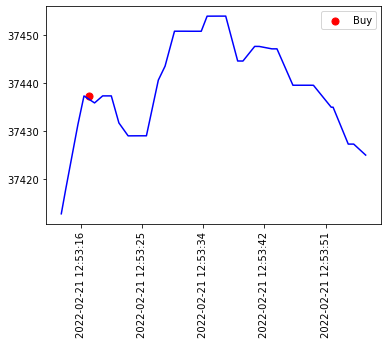

In [1]:
from IPython.display import clear_output
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
from binance.client import Client 
from binance import BinanceSocketManager 
import asyncio
import matplotlib.dates as mdates
import nest_asyncio
nest_asyncio.apply()

client = Client("ETaB6qaZr88YsFThPnvuCqewdcfMiKuHJkzRuXW6VUKlU8vqgqlx61xd8cueaZc4","tzAcaIb1Sio08sk9xcY38jvJ8CJcLvWehhOmpraGRRRuodD0dLI4MhZGaYdL7tAo")

def createFrame(msg): 
    df = pd.DataFrame([msg])
    df = df.loc[:,['s','E','p']]
    df.columns = ['symbol','Time','Price']
    df.Price = df.Price.astype(float)
    df.Time = pd.to_datetime(df.Time,unit = 'ms') 
    return df



def live_plot(df):

    time = df.Time.tolist()
    price = df.Price.tolist()
    # clear the output
    clear_output(wait=True)
    plt.clf()
    # convert the dates in number format to be used in the plot
    time = [mdates.date2num(date) for date in time]
    # plot the data
    plt.plot(time,price,color = 'blue')

    # plot the buy and sell markers
    if 'BTCUSDTorders' in engine.table_names():
        df2 = pd.read_sql("SELECT * FROM BTCUSDTorders", engine, parse_dates=['Time','transactTime'])
        df2 = df2.tail(10)
        df = pd.merge(df,df2,on = 'Time')
        price = df.Price.tolist()
        time = df.transactTime.tolist()
        time = [mdates.date2num(date) for date in time]
        buy_sell = df.side.tolist()
        plot_buy_sell(time,price,buy_sell)

    # rotate x-axis labels
    plt.xticks(rotation=90)
    # create x-axis formatter to show date and time precisely
    ax=plt.gca()
    xfmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    
    plt.show();

def plot_buy_sell(time,price,buy_sell):
    
    # put red dots on the graph for buy and green dots on the graph for sell
    for i in range(len(time)):
        if buy_sell[i].lower() == 'buy':
            plt.scatter(time[i],price[i],color = 'red',s = 50,label = 'Buy')
        elif buy_sell[i].lower() == 'sell':
            plt.scatter(time[i],price[i],color = 'green',s = 50,label = 'Sell')

    plt.legend(loc='best')

engine = sqlalchemy.create_engine("sqlite:///BTCUSDTstream")
# drop all the tables if they exist
if 'BTCUSDT' in engine.table_names():
    engine.execute("DROP TABLE BTCUSDT")

if 'BTCUSDTorders' in engine.table_names():
    engine.execute("DROP TABLE BTCUSDTorders")
    
async def main():

    while True: 
        bsm = BinanceSocketManager(client) 
        socket = bsm.trade_socket('BTCUSDT')   
        await socket.__aenter__()
        msg = await socket.recv() 
        frame = createFrame(msg)
        frame.to_sql("BTCUSDT", engine, if_exists = 'append', index = False)
        # GET THE LAST 100 ROWS OF THE TABLE
        df = pd.read_sql("SELECT * FROM BTCUSDT ORDER BY Time DESC LIMIT 100", engine, parse_dates=['Time'])
        live_plot(df)
        
        await asyncio.sleep(1)


def callback_main():
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    loop.run_until_complete(main())

def strategy(entry,lookback,qty,open_position = False):
    server_time = None 
    while True: 
        df = pd.read_sql('BTCUSDT',engine)
        lookbackperiod = df.iloc[-lookback:]
        cumret = (lookbackperiod.Price.pct_change() + 1).cumprod()-1
        if not open_position: 
            if cumret[cumret.last_valid_index()] > entry: 
                order = client.create_test_order(symbol = 'BTCUSDT',side = Client.SIDE_BUY,type = Client.ORDER_TYPE_MARKET,quantity = qty)
                ## save the order to the database

                # Testing code
                # ----------------------------------------------------------------------------------------------------------------------
                server_time = client.get_server_time()           
                print(server_time)
                df_time = pd.DataFrame(server_time,index = [0])
                df_time['Time'] = df.Time.iloc[-1]
                df_time.columns = ['transactTime','Time']
                df_time['side'] = 'BUY'
                df_time['transactTime'] = pd.to_datetime(df_time['transactTime'],unit = 'ms')
                print(df_time)
                df_time.to_sql('BTCUSDTorders',engine,if_exists = 'append',index = False)
                # ----------------------------------------------------------------------------------------------------------------------

                open_position = True 
                break 
                
    if open_position: 
        while True: 
            df = pd.read_sql('BTCUSDT',engine)
            # sincebuy = df.loc[df.Time > pd.to_datetime(order['transactTime'],unit = 'ms')]
            
            # testing code
            # ----------------------------------------------------------------------------------------------------------------------
            sincebuy = df.loc[df.Time > pd.to_datetime(server_time['serverTime'],unit = 'ms')]
            # ----------------------------------------------------------------------------------------------------------------------
            
            if len(sincebuy) > 1: 
                sincebuyret = (sincebuy.Price.pct_change() + 1).cumprod() -1 
                last_entry = sincebuyret[sincebuyret.last_valid_index()]
                if last_entry > 0.0015 or last_entry < -0.0015: 
                    order = client.create_test_order(symbol = 'BTCUSDT',side = Client.SIDE_SELL,type = Client.ORDER_TYPE_MARKET,quantity = qty)
                    

                    # Testing code
                    # ----------------------------------------------------------------------------------------------------------------------
                    server_time = client.get_server_time()
                    print(server_time)
                    df_time = pd.DataFrame(server_time,index = [0])
                    df_time['Time'] = df.Time.iloc[-1]
                    df_time.columns = ['transactTime','Time']
                    df_time['side'] = 'SELL'
                    df_time['transactTime'] = pd.to_datetime(df_time['transactTime'],unit = 'ms')
                    print(df_time)
                    df_time.to_sql('BTCUSDTorders',engine,if_exists = 'append',index = False)
                    # ----------------------------------------------------------------------------------------------------------------------

                    break


def run_strategy():
    while True:
        strategy(0.00015,10,0.001)

import threading
import time
t1 = threading.Thread(target = callback_main)
t2 = threading.Thread(target = run_strategy)
t1.start()
# Wait for 5 seconds before starting the second thread so that we have some values in the database to run the strategy on
time.sleep(5)
t2.start()